In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.constants import c
from scipy.fftpack import rfft
c = c.value*1e-6 #Speed of light in mm/ns
import peakdetect
# import scipy.optimize as op
# from scipy.interpolate import interp1d
# from scipy.optimize import curve_fit

In [2]:
T = 0.9763
R = 0.0234
A = 0.0003
L = 2.25*25.4
nu_fsr = c/(2*L)
print nu_fsr

2.62285615048


In [115]:
nu = np.r_[140:160:50000j] # Range of frequencies of interest
F = 4*R/(1-R)**2
delta = 2*np.pi*nu/nu_fsr
P = (T/(1-R))**2*1./(1 + F*np.sin(delta/2)**2)

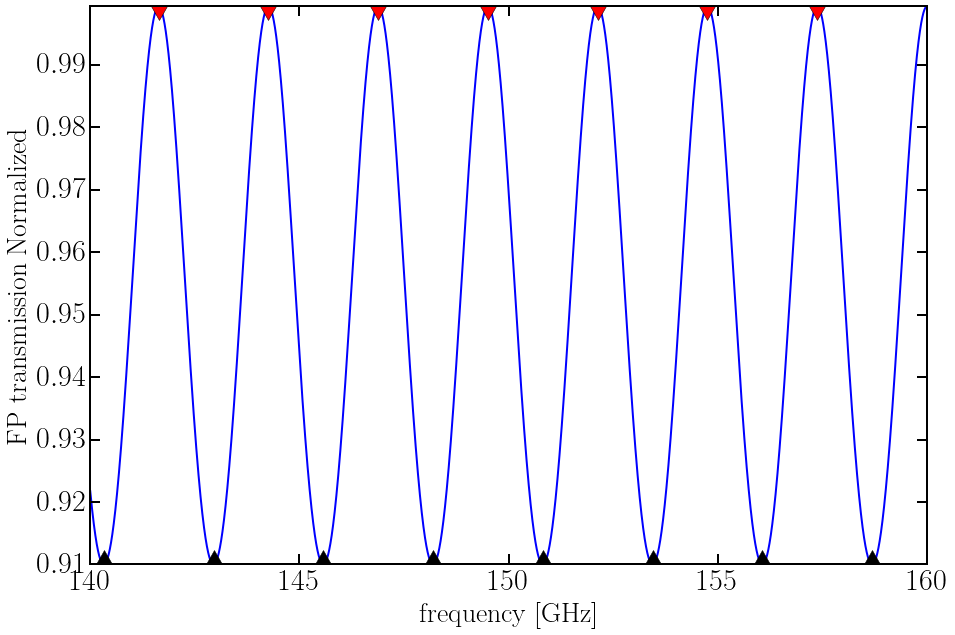

In [116]:
max_peaks, min_peaks = peakdetect.peakdetect(P,nu, lookahead=200)
max_nu,max_P = map(list, zip(*max_peaks))
min_nu, min_P = map(list, zip(*min_peaks))
max_indices = np.searchsorted(nu, max_nu)
min_indices = np.searchsorted(nu, min_nu)

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(nu, P, 'b')
ax.plot(max_nu, max_P, 'rd', markersize=20)
ax.plot(min_nu, min_P, 'kd', markersize=20)
ax.axis('tight')
ax.set_xlabel('frequency [GHz]')
ax.set_ylabel('FP transmission Normalized');

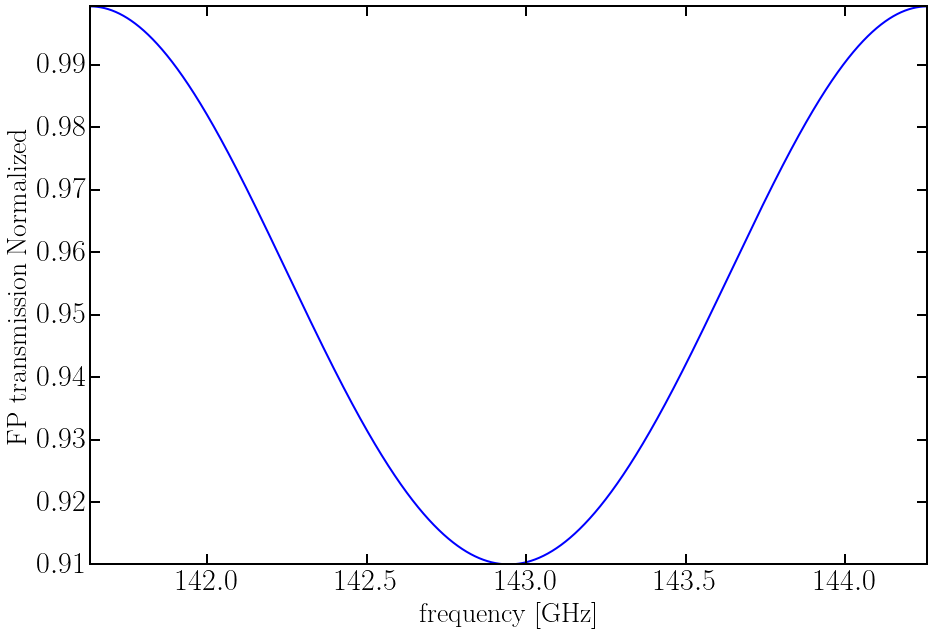

In [117]:
# Use the max peaks to determine the range used in the fourier fitting
mask = np.logical_and(nu >= nu[np.where(nu == max_nu[0])[0]], nu <= nu[np.where(nu == max_nu[1])[0]])

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(nu[mask], P[mask], 'b')
ax.axis('tight')
ax.set_xlabel('frequency [GHz]')
ax.set_ylabel('FP transmission Normalized');

In [118]:
index = np.arange(1, (len(P[mask])+1)/2)
print len(index)
N = len(P[mask])
print N
y = rfft(P[mask])/N
b0 = y[0]
y*=2
c_k = y[1:N:2]
s_k = y[2:N:2]
b_k = (c_k**2 + s_k**2)**0.5
# nu_0k = np.arctan2(s_k, c_k)/2/np.pi

3279
6559


In [119]:
fourier_cterm = lambda ck, k: ck*np.cos(2*np.pi*nu/nu_fsr*k)
fourier_sterm = lambda sk, k: sk*np.sin(2*np.pi*nu/nu_fsr*k)
#Let's try and get the FP fringes using the series expansion
A = (T/(1-R))**2*((1-R)/(1 + R))
R_k = R**index
P_series = A*(1 + 2*np.sum(map(fourier_cterm, R_k, index),axis=0))

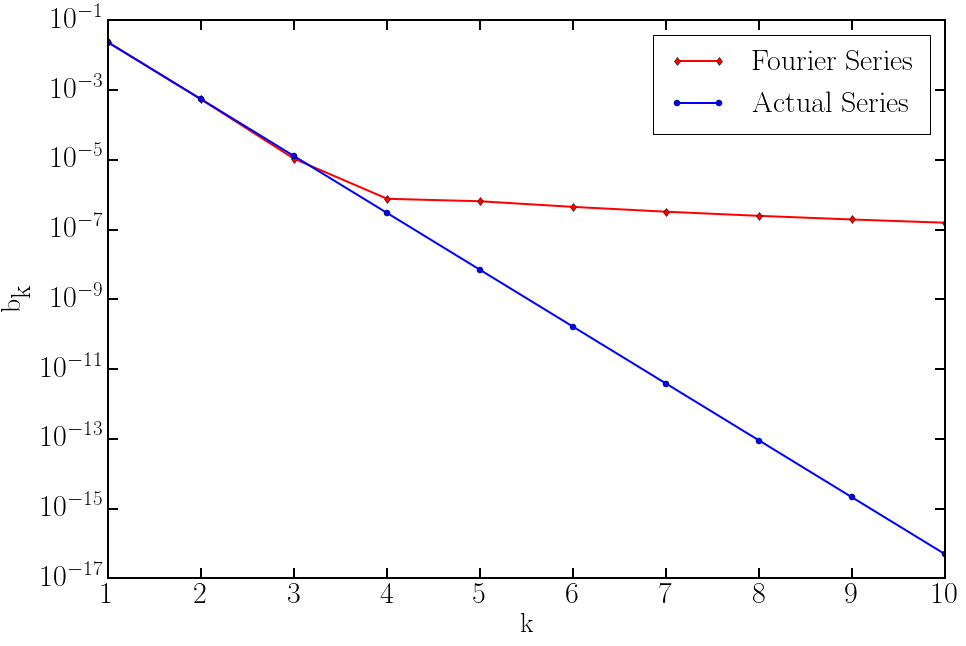

In [120]:
fig, ax = plt.subplots(figsize=(15,10))
ax.semilogy(index[:10], b_k[:10]/(2*b0), 'rd-', label='Fourier Series')
ax.semilogy(index[:10], R_k[:10], 'bo-', label='Actual Series')
# ax.set_xlim(0.0, 20)
# ax.axis('tight')
ax.set_xlabel('k')
ax.legend(loc='best')
ax.set_ylabel(r'$\textrm{b}_{\textrm{k}}$');

In [121]:
P_fseries = b0 + np.sum(map(fourier_cterm, c_k, index),axis=0) + np.sum(map(fourier_sterm, s_k, index),axis=0)
error = P - P_fseries

2.14790486659e-05


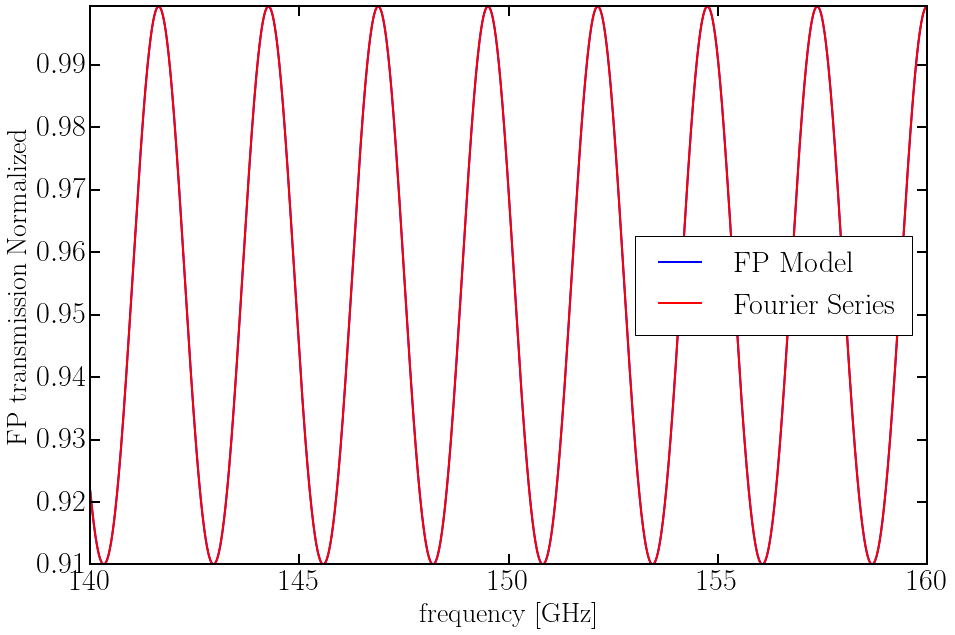

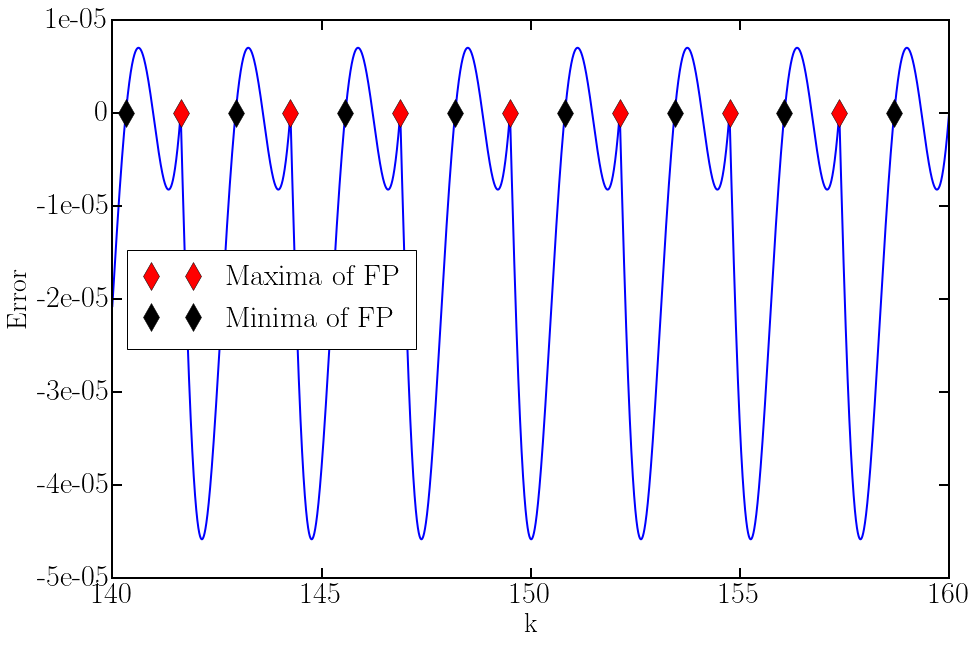

In [122]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(nu, P, 'b', label='FP Model')
ax.plot(nu, P_fseries, 'r', label='Fourier Series')
ax.axis('tight')
ax.set_xlabel('frequency [GHz]')
ax.set_ylabel('FP transmission Normalized');
ax.legend(loc='best')

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(nu, error)  # Fourier Coefficients 
ax.plot(max_nu, error[max_indices], 'rd', markersize=20, label='Maxima of FP')
ax.plot(min_nu, error[min_indices], 'kd', markersize=20, label='Minima of FP')
# ax.axis('tight')
ax.set_xlabel('k')
ax.set_yticklabels(['%1.2g' %t for t in ax.get_yticks()]);
ax.set_ylabel('Error')
ax.legend(loc='best')
print np.average(error**2)**0.5

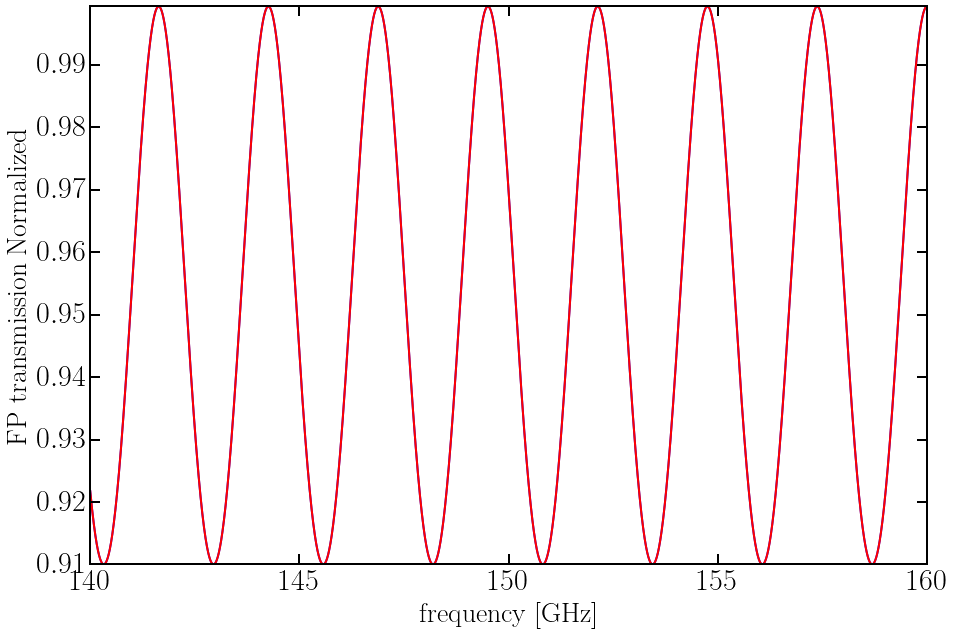

In [123]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(nu, P, 'b')
ax.plot(nu, P_series, 'r')
ax.axis('tight')
ax.set_xlabel('frequency [GHz]')
ax.set_ylabel('FP transmission Normalized');

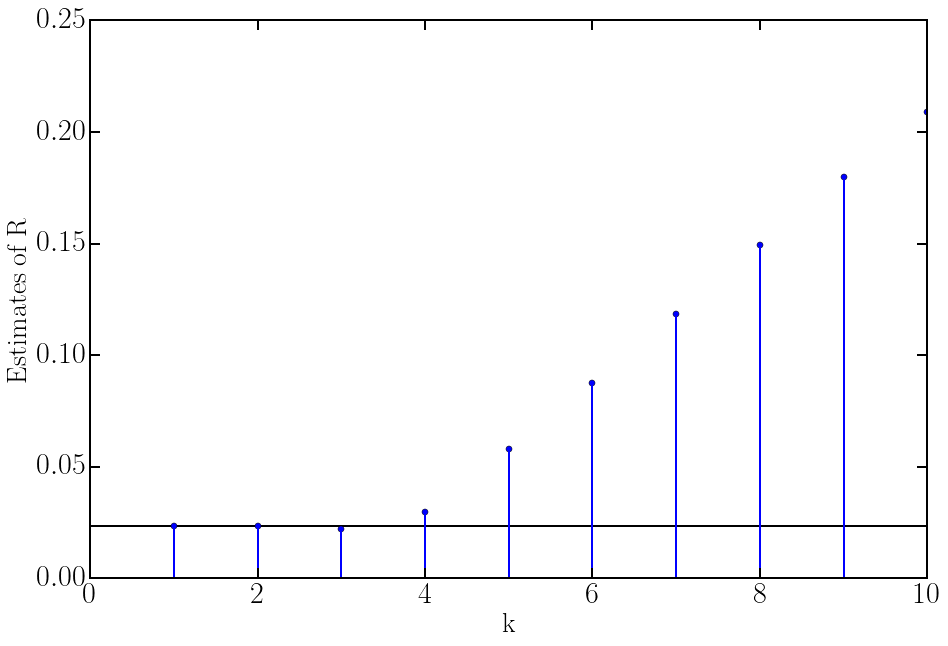

In [124]:
# Let's see if the fourier coefficients reproduce R
R_try = (b_k/(2*b0))**(1./index)
fig, ax = plt.subplots(figsize=(15,10))
ax.stem(index[:10], R_try[:10])
ax.hlines(R, 0, 10.0, colors=u'k')
ax.set_xlim(0.0, 10.0)
# ax.axis('tight')
ax.set_xlabel('k')
ax.set_ylabel(r'Estimates of R');

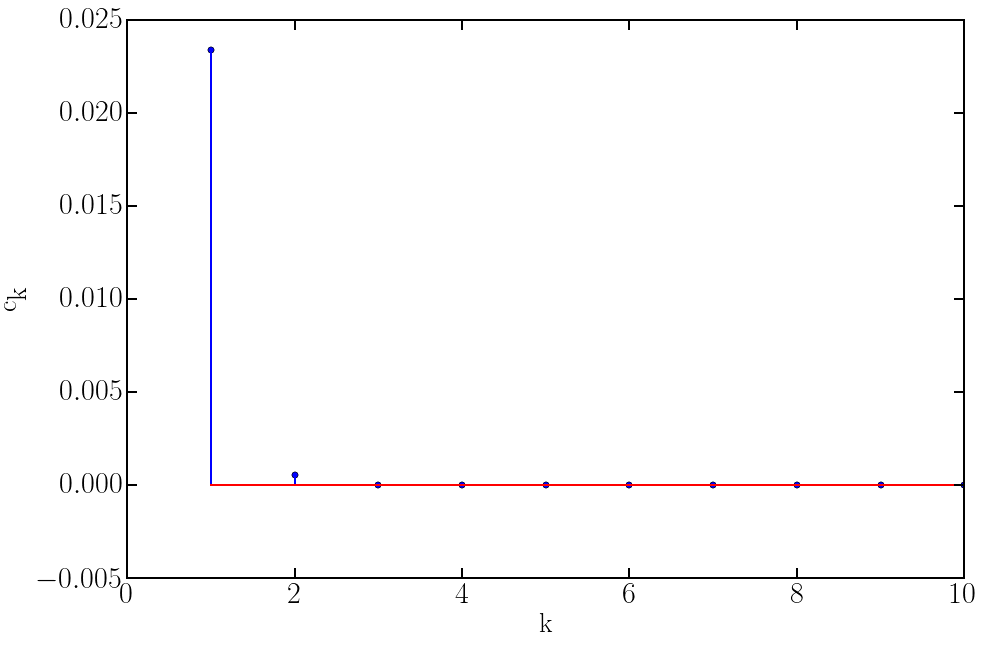

In [125]:
fig, ax = plt.subplots(figsize=(15,10))
ax.stem(index, c_k/(2*b0), 'r')  # Fourier Coefficients 
ax.stem(index, R_k, 'b')
ax.set_xlim(0.0, 10.0)
# ax.axis('tight')
ax.set_xlabel('k')
ax.set_ylabel(r'$\textrm{c}_{\textrm{k}}$');

In [ ]:
ratio = R_k/(c_k/(2*b0))
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(index, ratio, 'r')  
ax.set_xlim(0.0, 10.0)
# ax.axis('tight')
ax.set_xlabel('k')
ax.set_ylabel(r'Ratio');

In [ ]:
index2 = np.arange(len(P[mask]))
y = rfft(error[mask])/N
fig, ax = plt.subplots(figsize=(15,10))
ax.stem(index2, y.real, 'b')  # Fourier Coefficients 
# ax.stem(index2, y.imag, 'b')
ax.set_xlim(0.0, 10.0)
# ax.axis('tight')
ax.set_xlabel('k');

In [ ]:
len(index)

In [11]:
ax.stem?

In [21]:
c_k[10]

-6.1279361197892353e-06

In [81]:
y = np.array([0,1,2,3,4,5,6,7,8,9,10])
y[1:-1:2]

array([1, 3, 5, 7, 9])

In [101]:
print y[1:11:2]
print y[2:11:2]
len(index)

[  4.46862586e-02   9.81126812e-04  -3.34721930e-06  -1.39691305e-05
  -8.97118158e-06]
[  9.92459057e-05   4.35809269e-06  -2.22934307e-08  -1.24090137e-07
  -9.96118265e-08]


327

In [98]:
y[1:11:2]

array([1, 3, 5, 7, 9])